In [2]:
# __future__ import should always be first
from __future__ import annotations

# Standard library imports
from collections import defaultdict

# Third-party imports
import copy
import os
import glob
import torch
import numpy as np
import torch.nn as nn
from torch.distributions.categorical import Categorical

# Gymnasium & Minigrid imports
import gymnasium as gym  # Correct way to import Gymnasium
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.constants import DIR_TO_VEC
from minigrid.core.grid import Grid
from minigrid.core.actions import Actions
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from gymnasium.utils.play import play
import pandas as pd
# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation


from dataclasses import dataclass, field

from moviepy import VideoFileClip, TextClip, CompositeVideoClip
from moviepy import ImageSequenceClip

from typing import Optional, List, Dict, Tuple

# Environment

In [3]:

class SimpleEnv(MiniGridEnv):
    def __init__(
            self, 
            size=10, 
            agent_start_pos=(1, 8), 
            agent_start_dir=0, 
            max_steps=256, 
            **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.goal_pos = (8, 1)
        
        
        
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=max_steps,
            **kwargs,
        )

        self.action_space = gym.spaces.Discrete(3)
    @staticmethod
    def _gen_mission():
        return "Find the shortest path"

    def _gen_grid(self, width, height):
        #create gird
        self.grid = Grid(width, height)
        #place barrier
        self.grid.wall_rect(0, 0, width, height)
        #place goal
        self.put_obj(Goal(), 8, 1)
        #place walls
        for i in range(1, width // 2):
            self.grid.set(i, width - 4, Wall())
            self.grid.set(i + width // 2 - 1, width - 7, Wall())
        #place agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos #check this
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "find the shortest path"
    
    def count_states(self):
        free_cells = sum(1 for x in range(self.grid.width)
                      for y in range(self.grid.height)
                      if not self.grid.get(x, y)) * 4
        return free_cells 


In [4]:
env = SimpleEnv(render_mode = None)
#env.reset needed to bypass the step counter function which is otherwise needed but doesn't exist in SimpleEnv
env.reset();

# Model State Class

In [5]:
@dataclass

class ModelState:
    #tables and arrays
    Q_table: np.ndarray = field(default_factory=lambda: np.array([]))
    Pi_a_s: np.ndarray = field(default_factory=lambda: np.array([]))
    P_s_given_s_a: np.ndarray = field(default_factory=lambda: np.array([]))
    P_s_by_s: np.ndarray = field(default_factory=lambda: np.array([]))
    
    allowed_state_idx: np.ndarray = field(default_factory=lambda: np.array([]))
    
    #scalars
    beta: Optional[float] = None
    num_actions: Optional[int] = None
    num_states: Optional[int] = None

    #lists
    info_to_go_term_training: List[float] = field(default_factory=list)
    pi_analysis_term_training: List[float] = field(default_factory=list)

    #list for P_s
    positions_directions_list_ps: List[float] = field(default_factory=list)
    positions_directions_list_neglogps: List[float] = field(default_factory=list)

    #dictionaries
    transition_counts: Dict = field(default_factory=dict)





In [6]:
#instantiate state instance, can also import from another file if needed
state = ModelState()


# SandBox State
for experimenting

In [7]:
sandbox_state = copy.deepcopy(state)

# Utility Functions

In [8]:
class GridMixin:
    def position_to_state_index(self, tuple_position = None): 
        grid_width = self.env.grid.width -2
        if tuple_position is None:
            direction = self.env.agent_dir
            x, y = self.env.agent_pos

        else:
            if not isinstance(tuple_position, tuple) or len(tuple_position) != 3:
                raise ValueError(f"Invalid position format: {tuple_position}")
            x, y, direction = tuple_position
        return np.int64(((y-1) * grid_width + (x-1)) * 4 + direction) 
    
    def state_index_to_position(self, state_idx):
        """Converts a scalar state index back into (x, y, direction)."""
        grid_width = self.env.grid.width-2
        
        direction = state_idx % 4
        linear_idx = state_idx // 4

        y, x = divmod(linear_idx, grid_width)  # Convert to (x, y)
        
        return x+1, y+1, direction
    
    def find_state_indexes(self, env): #took out that in accepts env, bc redundant
        """Counts all states except walls and barriers"""
        state_indexes_list = []
        for x in range(1, env.grid.width-1):
            for y in range(1, env.grid.height-1):
                if env.grid.get(x, y) is None: #grabs all empty spaces
                    for direction in range(4):
                        state_index = self.position_to_state_index((x, y, direction))
                        state_indexes_list.append(state_index)
        return state_indexes_list  
    
    def next_state_index(self, current_state_idx, action):
        # Convert current state index into (x, y, direction)
        x, y, direction = self.state_index_to_position(current_state_idx )
        
        if action == 0:  # Turn left
            direction = (direction - 1) % 4
        elif action == 1:  # Turn right
            direction = (direction + 1) % 4
        elif action == 2:  # Move forward
            if direction == 0:   # looking right increase x
                x += 1
            elif direction == 1: # looking down increase y
                y += 1
            elif direction == 2: # facing left: decrease x
                x -= 1
            elif direction == 3: # looking up: decrease y
                y -= 1
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # Convert the new (x, y, direction) back to a state index.
        next_state = self.position_to_state_index((x, y, direction))
        if next_state not in self.state.allowed_state_idx:
            # If the next state is not allowed, return the current state
            return current_state_idx
        return next_state
    
    def find_all_next_states(self):
        """Find all possible next states for each state and action."""
        for state in self.state.allowed_state_idx:
            for action in range(self.state.num_actions):
                next_state = self.next_state_index(state, action)
                self.state.P_s_given_s_a[state, action, next_state] = 1
            

    def find_connected_states(self):
        """
        Build and return a connectivity matrix P_s_by_s where the element at [state, next_state]
        is given by the probability from self.Pi_a_s for the action that leads from state to next_state.
        """
        # Reset the connectivity matrix at the beginning.
        self.state.P_s_by_s = np.zeros((self.state.num_states, self.state.num_states))
        # Loop over all states.
        for state in self.state.allowed_state_idx:
            # Loop over all actions for the state.
            for action in range(self.state.num_actions):
                # Find the next state: assume a deterministic transition where exactly one entry is 1.
                next_state = np.argmax(self.state.P_s_given_s_a[state, action, :])
                # Set the connectivity matrix: you might choose to sum if multiple actions lead to the same state.
                self.state.P_s_by_s[state, next_state] += self.state.Pi_a_s[state, action]
        

    def calculate_pi(self):
        """Calculate the policy from the Q-table."""
        denominator = np.sum((np.exp(self.state.beta * self.Q_table)), axis = 1, keepdims=True) # e^(beta * Q(s,a)) summed over all actions for each state
        numerator = np.exp(self.state.beta * self.Q_table) # e^(beta * Q(s,a))
        pi = numerator/denominator
        
        assert np.all(np.isclose(np.sum(pi, axis=1), np.ones(pi.shape[0]), atol=1e-5)), "Policy does not sum to 1 for all states."
        return pi


# TRAIN

In [8]:
"""Various run functions, simple run, run with collecting stats, and run multiple betas"""

class QTrainer(GridMixin):
    def __init__(
        self,
        env,
        state: ModelState,
        learning_rate = 0.9,
        discount_factor = 0.9,
        epochs = 200,
        beta = 5
         
    ):
        self.env = env # MiniGrid environment called from the class Minigrid
        self.epochs = epochs
        self.state = state
        self.state.allowed_state_idx = self.find_state_indexes(env)
        self.state.num_states = ((env.width -2) * (env.height -2) *4)
        self.state.num_actions = env.action_space.n
        #shapes defined for first time
        self.state.P_s_given_s_a = np.zeros((self.state.num_states, self.state.num_actions, self.state.num_states)) # P(s'|s,a) matrix
        self.state.P_s_by_s = np.zeros((self.state.num_states, self.state.num_states)) # P(s'|s) matrix
        self.state.Pi_a_s = np.full((self.state.num_states, self.state.num_actions), 1/self.state.num_actions) # pi(s,a) matrix

        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.state.num_actions)) # Q table has goal states in it as well
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        
        self.state.beta = beta

        
        self.Pi_a = np.zeros(self.state.num_actions)
        self.P_s = np.zeros(self.state.num_states)
        
       
        
        
        #these lists and in state to be used for plotting
        self.state.info_to_go_term_training = []
        self.state.pi_analysis_term_training = []

    
    def train(self):
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        


        self.steps = 1

        for epoch in range(self.epochs):
            
            current_state = np.random.choice(self.state.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir
            # print(f"Epoch {epoch}: Starting state: {current_state}")
            # print(f"Epoch {epoch}: Starting position: {self.state_index_to_position(current_state)}")

            epoch_info_to_go = []
            epoch_pi_analysis = []
            initial_s = np.zeros(self.state.num_states)
            initial_s[current_state] = 1

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.state.num_actions), p = self.state.Pi_a_s[current_state])

                


                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()
                # print(f"next_state: {next_state}")
                # print(f"next  step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")
                #reward (-1 for each step thats not the gaol)
                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.state.Pi_a_s = self.calculate_pi()

                #calculate the P_s 
                self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
                self.Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, self.steps)
                self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
                assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
                #calculate the info to go 
                info_to_go = -np.log(self.P_s[next_state] + 1e-15)  
                
                #calculate policy log term
                rows_of_actions_per_state = []
                for s in range(self.state.num_states):
                    row = self.state.Pi_a_s[s] * self.P_s[s]
                    # print(f'row in Pi:{self.Pi_a_s[s]} ')
                    # print(f'row {row}')
                    rows_of_actions_per_state.append(row)
                self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
                
                for a in range(self.state.num_actions):
                    pi_analysis = (np.log(self.state.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

                #add calculated term into the list:
                epoch_info_to_go.append(info_to_go)
                epoch_pi_analysis.append(pi_analysis)

                #update state
                if next_state in goal_states:
                    break
                # assert(False)
                current_state = next_state
                #recaluclate P_s_by_s because its based off Pi_a_s which is based on Q_table
                self.find_connected_states()

            self.state.info_to_go_term_training.append(epoch_info_to_go)
            self.state.pi_analysis_term_training.append(epoch_pi_analysis)


        """ Perform Blahut-Arimoto-like updates on the Probabilistic Q Learning System """


In [9]:
trainer = QTrainer(env, state, beta =5)

In [10]:
trainer.train()

In [10]:
trainer.find_connected_states()

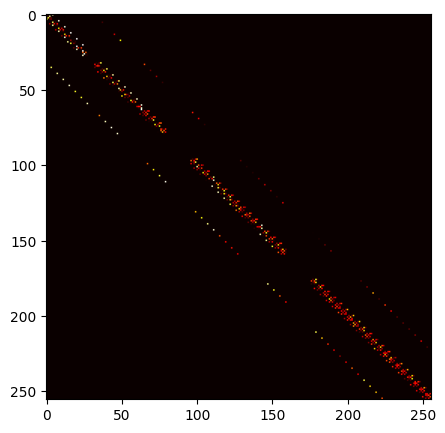

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(trainer.state.P_s_by_s, cmap='hot')#, interpolation='nearest')

In [302]:
#currently testing, this uses a trained pi
class Sandbox(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        state: ModelState
        learning_rate = 0.9
        discount_factor = 0.9
        epochs = 50
        beta = 5
        self.epochs = epochs
        self.state = state
        self.state.allowed_state_idx = self.find_state_indexes(env)
        self.state.num_states = ((env.width -2) * (env.height -2) *4)
        self.state.num_actions = env.action_space.n
        #shapes defined for first time
        self.state.P_s_given_s_a = np.zeros((self.state.num_states, self.state.num_actions, self.state.num_states)) # P(s'|s,a) matrix
        self.state.P_s_by_s = np.zeros((self.state.num_states, self.state.num_states)) # P(s'|s) matrix
        self.state.Pi_a_s = np.full((self.state.num_states, self.state.num_actions), 1/self.state.num_actions) # pi(s,a) matrix

        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.state.num_actions)) # Q table has goal states in it as well
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        
        self.state.beta = beta

        
        self.Pi_a = np.zeros(self.state.num_actions)
        self.P_s = np.zeros(self.state.num_states)
        
       
        
        
        
        
    """ Perform training using BA updates on the Probabilistic Q Learning System """


    def train_BA(self):
        max_ba_iters = 5 #max iterations for the Blahut-Arimoto update
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        

        for epoch in range(self.epochs):
            self.steps = 1
            current_state = np.random.choice(self.state.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir

            initial_s = np.zeros(self.state.num_states)
            initial_s[current_state] = 1

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.state.num_actions), p = self.state.Pi_a_s[current_state])
                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()

                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.state.Pi_a_s = self.calculate_pi()

                self.find_connected_states() #P_s fixed by old Pi_a_s
                Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, self.steps)
                P_s = np.dot(initial_s.T, Ps_s_matrix) #define P(s)
                print(f"Epoch {epoch}: P(s)[s] {P_s[current_state]}")
                print(f"Epoch {epoch}: P(s)[next_state] {P_s[next_state]}")

              
                assert np.isclose(np.sum(P_s), 1), f"Sum of P(s) is not 1: {np.sum(P_s)}"
                #######loop of calculations#####
                for _ in range(max_ba_iters):
                    # self.find_connected_states() #P_s fixed by old Pi_a_s
                    # Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, self.steps)
                    # P_s = np.dot(initial_s.T, Ps_s_matrix) #define P(s)
                    # assert np.isclose(np.sum(P_s), 1), f"Sum of P(s) is not 1: {np.sum(P_s)}"
                       
                    
                    # pi_a_sums = []
                    # for s in range(self.state.num_states):
                    #     row = self.state.Pi_a_s[s] * P_s[s]
                    #     pi_a_sums.append(row)
                    # pi_a = np.sum(np.asarray(pi_a_sums), axis=0)
                    pi_a = P_s@self.state.Pi_a_s
                
                    assert np.isclose(np.sum(pi_a), 1), f"Sum of Pi_a is not 1: {np.sum(pi_a)}"

                    #calculate Z
                    element_wise_a_by_q_table = pi_a * np.exp(self.state.beta * self.Q_table)
                    
                    zeta = np.sum((element_wise_a_by_q_table), axis = 1)
                    
                    #calculate for policy using partition fuction

                    new_Pi_a_s = (pi_a * np.exp(self.state.beta * self.Q_table))/ zeta.reshape(-1,1) 
                    self.state.Pi_a_s = new_Pi_a_s

                      # Frobenius norm for matrix difference
                    
                diff = np.linalg.norm(new_Pi_a_s - self.state.Pi_a_s, ord='fro')
                print(f"Epoch {epoch}: Frobenius norm difference: {diff:.4f}") # with percent
                #update state
                if next_state in goal_states:
                    print(f"Goal reached at state {next_state} in epoch {epoch} after {self.steps} steps.")
                    break
                # assert(False)
                current_state = next_state
                print(f"Epoch {epoch}: Step {self.steps}, Current state: {current_state}")
                self.steps += 1

               

      




        
    

In [52]:
#currently testing, this uses a trained pi
class FreeEnergySandbox(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        state: ModelState
 
 
        beta = 5
        self.epochs = 500
        self.state = state
        self.state.allowed_state_idx = self.find_state_indexes(env)
        self.state.num_states = ((env.width -2) * (env.height -2) *4)
        self.state.num_actions = env.action_space.n
        #shapes defined for first time
        self.state.P_s_given_s_a = np.zeros((self.state.num_states, self.state.num_actions, self.state.num_states)) # P(s'|s,a) matrix
        self.state.P_s_by_s = np.zeros((self.state.num_states, self.state.num_states)) # P(s'|s) matrix
        self.state.Pi_a_s = np.full((self.state.num_states, self.state.num_actions), 1/self.state.num_actions) # pi(s,a) matrix
      
        self.Free_energy_table = np.full((self.state.num_states, self.state.num_actions), 100) # Free energy table


        
        self.state.beta = beta

        
        self.Pi_a = np.full((self.state.num_actions), 1/self.state.num_actions)
        self.P_s = np.zeros(self.state.num_states)
        
       
        
        
        
        
    """ Perform training using BA updates on the Probabilistic Q Learning System """


    def train_BA(self):
        max_ba_iters = 10 #max iterations for the Blahut-Arimoto update
     #tolerance for convergence
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        

        for epoch in range(self.epochs):
            self.steps = 1
            current_state = np.random.choice(self.state.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir

            initial_s = np.zeros(self.state.num_states)
            initial_s[current_state] = 1

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.state.num_actions), p = self.state.Pi_a_s[current_state])
                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()

                reward = 0 if next_state in goal_states else -1

                self.find_connected_states() #P_s fixed by old Pi_a_s
                Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, self.steps)
                P_s = np.dot(initial_s.T, Ps_s_matrix) #define P(s)
                
                assert np.isclose(np.sum(P_s), 1), f"Sum of P(s) is not 1: {np.sum(P_s)}"
                
                #calculate the Free energy
                F_0 = (-np.log(P_s[next_state]+ 1e-15)) - (self.state.beta * reward)
                # print(f" P_s[current_state]: {P_s[current_state]}")
                # print (f"P_s[next_state]: {P_s[next_state]}")
                
                G_0 = 0

                for a in range(self.state.num_actions):
                    G_0 += (np.log(self.state.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15) + self.Free_energy_table[next_state, a]) * self.state.Pi_a_s[next_state, a]
                        # print(f'G_0: {G_0}')
                F_0 += G_0 

                self.Free_energy_table[current_state, action] = F_0 #np.min([F_0, 200]) #    #np.min([F_0, 50])
                #self.Free_energy_table[self.state.allowed_state_idx] = self.Free_energy_table[self.state.allowed_state_idx] - np.mean(self.Free_energy_table[self.state.allowed_state_idx])
                # print(f"F_0:{F_0}")
                    # self.Free_energy_table[self.state.allowed_state_idx] = self.Free_energy_table[self.state.allowed_state_idx] - np.mean(self.Free_energy_table[self.state.allowed_state_idx])
                
                

                #######loop of calculations#####
                for _ in range(max_ba_iters):


                    self.Pi_a = P_s@self.state.Pi_a_s 
                
                  
                    
                    assert np.isclose(np.sum(self.Pi_a), 1), f"Sum of Pi_a is not 1: {np.sum(self.Pi_a)}"

                    
                    # 1) log π(a)  — shape (A,)
                    log_pi_a = np.log(self.Pi_a + 1e-15)

                    # 2) log-joint   log π(a) − β F(s,a)  — broadcast to shape (S,A)
                    log_joint = log_pi_a - self.state.beta * self.Free_energy_table

                    # 3) row-shift: subtract max in each state to keep exp() ≤ 1
                    log_joint -= log_joint.max(axis=1, keepdims=True)

                    # 4) exponentiate and normalise each row
                    new_Pi_a_s = np.exp(log_joint)
                    new_Pi_a_s /= new_Pi_a_s.sum(axis=1, keepdims=True)   # Σ_a π(a|s)=1
                    
                    
                    
                    
                    
                    #calculate Z




                    # element_wise_a_by_q_table = self.Pi_a * np.exp(-  self.Free_energy_table)
                    
                    # zeta = np.sum((element_wise_a_by_q_table), axis = 1)
                   
                    
                    # #calculate for policy using partition fuction

                    # new_Pi_a_s = (self.Pi_a * np.exp(-  self.Free_energy_table))/ zeta.reshape(-1,1) 
                    diff = np.linalg.norm(new_Pi_a_s - self.state.Pi_a_s, ord='fro')
                    # print(f"Epoch {epoch}: Frobenius norm difference: {diff:.4f}") # with percent
                    self.state.Pi_a_s = new_Pi_a_s

                      # Frobenius norm for matrix difference
                    

                #update state
                if next_state in goal_states:
                    # print(f"Goal reached at state {next_state} in epoch {epoch} after {self.steps} steps.")
                    break
                # assert(False)
                current_state = next_state
                # print(f"Epoch {epoch}: Step {self.steps}, Current state: {current_state}")
                self.steps += 1

               

      




        
    

In [11]:
# start the class with the sandboxed state
sandbox = Sandbox(env, sandbox_state)

NameError: name 'Sandbox' is not defined

In [53]:
env = SimpleEnv(render_mode = None)
#env.reset needed to bypass the step counter function which is otherwise needed but doesn't exist in SimpleEnv
env.reset();

In [126]:
#optional switch out env to human mode
env_human = SimpleEnv(render_mode='human')
env_human.reset()
sandbox.env = env_human

In [ ]:
sandbox.train_BA()

In [54]:
free =FreeEnergySandbox(env, sandbox_state)

In [55]:
free.train_BA()

In [31]:
sandbox.step_count

45

In [30]:
len(sandbox.info_state_calculation)

44

In [56]:
class Sandbox_run(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        state: ModelState

    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        self.step_count = 0  # Track steps to prevent infinite loops

        while not done and self.step_count < 100:  # Prevent infinite loops
  
            action = np.random.choice(np.arange(self.state.num_actions), p=self.state.Pi_a_s[current_state])  # Choose best action
            next_obs, _, done, _, _ = self.env.step(action)  # Take action
            next_state = self.position_to_state_index()  # Convert new state
            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step
            current_state = next_state  # Update current state
            self.step_count += 1

In [34]:
sanbox_run.state.state.Pi_a_s

AttributeError: 'ModelState' object has no attribute 'state'

In [57]:
sanbox_run = Sandbox_run(env, sandbox_state)

In [39]:
sanbox_run.state.Pi_a_s

array([[1.29499819e-115, 6.26072268e-183, 1.00000000e+000],
       [9.35762297e-014, 1.00000000e+000, 9.96473301e-062],
       [1.00000000e+000, 2.86251858e-020, 1.13797987e-035],
       [2.48891883e-198, 1.00000000e+000, 8.69485652e-164],
       [2.48891883e-213, 2.49772757e-137, 1.00000000e+000],
       [7.64060659e-144, 1.80485139e-050, 1.00000000e+000],
       [6.30511676e-016, 1.00000000e+000, 4.23337159e-079],
       [2.85242279e-096, 9.99999807e-001, 1.92874948e-007],
       [1.05365183e-306, 5.46287446e-285, 1.00000000e+000],
       [8.19401262e-040, 1.00000000e+000, 1.38389653e-072],
       [3.48110684e-072, 3.04823495e-098, 1.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 7.09945017e-279],
       [1.67110597e-291, 4.49212861e-248, 1.00000000e+000],
       [1.00000000e+000, 9.35762297e-014, 5.46287446e-255],
       [1.00000000e+000, 3.70695639e-120, 2.19487851e-057],
       [1.05365183e-291, 1.00000000e+000, 3.23455268e-207],
       [5.83788690e-272, 2.84236370e-187

In [58]:
env_human = SimpleEnv(render_mode='human')
env_human.reset()
sanbox_run.env = env_human

In [59]:
sanbox_run.run_policy_2()

# RUN Trained model

In [404]:
class QRunner(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        
    
    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        self.step_count = 0  # Track steps to prevent infinite loops

        while not done and self.step_count < 100:  # Prevent infinite loops
  
            action = np.random.choice(np.arange(self.state.num_actions), p=self.state.Pi_a_s[current_state])  # Choose best action
            next_obs, _, done, _, _ = self.env.step(action)  # Take action
            next_state = self.position_to_state_index()  # Convert new state
            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step
            current_state = next_state  # Update current state
            self.step_count += 1



    


In [405]:
runner = QRunner(env, state)

In [406]:
#optional switch out env to human mode
env_human = SimpleEnv(render_mode='human')
runner.env = env_human

In [407]:
runner.run_policy_2()

# Model Data Collection

In [33]:
"""This class can make new calculations, can't change any of the parameters of the class train or run"""

class QAnalyzer(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        

        
      
        

        
    #get probability of state using time probability
    def get_P_st(self, T):
        self.env.reset()[0]  # Reset environment
        initial_state = self.position_to_state_index()  # Convert starting position to index
        initial_s = np.zeros(self.state.num_states)
        initial_s[initial_state] = 1
        self.find_connected_states() #depends on self.state.Pi_a_s

        Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, T)
        P_s = np.dot(initial_s.T, Ps_s_matrix)   #define P(s)

        assert(np.isclose(np.sum(P_s), 1)), f"Sum of P(s) is not 1: {np.sum(P_s)}"

        return P_s
    
    def alt_P_r_s(self, state_probabilities):
        """Separate from the state index the actual position and direction of the agent."""
        positions_directions = {}
        
        
        for state_idx, probability in enumerate(state_probabilities):
            x, y, direction = self.state_index_to_position(state_idx)
            
            # Store in a dictionary under 'position' and 'direction'
            positions_directions[state_idx] = {
                "position": (x, y),
                "direction": direction,
                "probability": probability
            }
        return positions_directions

    def get_pdl(self, T):
        self.state.positions_directions_list_ps = []
        for t in range(T):
            tmp_probs = self.get_P_st(t) #defined here
            pos_dict = self.alt_P_r_s(tmp_probs) #defined here
    
            self.state.positions_directions_list_ps.append(pos_dict)

    def get_neglog_pdl(self, T):
        self.state.positions_directions_list_neglogps = []
        for t in range(T):
            tmp_probs = self.get_P_st(t)
            pos_dict = self.alt_P_r_s(-np.log((tmp_probs)+ 1e-15))
            self.state.positions_directions_list_neglogps.append(pos_dict)
    
    """Decision through time"""

    def get_Pi_a(self, T):
        self.env.reset()[0]  # Reset environment
        initial_state = self.position_to_state_index()  # Convert starting position to index
        initial_s = np.zeros(self.state.num_states)
        initial_s[initial_state] = 1
        self.find_connected_states()

        Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, T)
        P_s = np.dot(initial_s.T, Ps_s_matrix)   #define P(s)
        
        pi_a_sums = []
        for s in range(self.state.num_states):
            row = self.state.Pi_a_s[s] * P_s[s]
            pi_a_sums.append(row)
        pi_a_sums = np.sum(np.asarray(pi_a_sums), axis=0)
        return pi_a_sums

    def get_decision(self, T):
        decisions = []
        for t in range(T):
            #tmp_probs is a list, each item is a vector of state probabilities for each time
            #tmp_probs = self.get_P_st(t)
            pi_a = self.get_Pi_a(t) #specific time dependent a array
    
            decision_terms = []
            for state in range(self.state.num_states): #pick out a single state probability from all states
                decision_term = 0
                if state in self.state.allowed_state_idx:
                # action = np.random.choice(np.arange(self.state.num_actions), p=self.state.Pi_a_s[state])
                # next_state = np.argmax(self.state.P_s_given_s_a[state, action])
                    for a in range(self.state.num_actions):
                        
                        decision_term +=((np.log(self.state.Pi_a_s[state , a] + 1e-15) - np.log(pi_a[a]+ 1e-15) ) * self.state.Pi_a_s[state, a])   #this is the decision term for that specific state, it is a sum over all actions
                        #gives a decision term value for that specific state
                decision_terms.append(decision_term)
        
            decisions.append(decision_terms)
        return decisions
    

    def get_decision_terms(self, T):
        """Get decision terms for each time step and store them as position dictionaries."""
        decision_terms = self.get_decision(T)
        self.state.positions_directions_list_decisions = []

        for t_decisions in decision_terms:
            pos_dict = self.alt_P_r_s(t_decisions)  # <- reuse existing function!
            self.state.positions_directions_list_decisions.append(pos_dict)

    """Information to go delta term"""

    def get_info_to_go_delta(self, initial_state, time, state, action):
        #this function is state dependent
        
        Ps_s_matrix = np.linalg.matrix_power(self.state.P_s_by_s, time)
        P_s = np.dot(initial_state.T, Ps_s_matrix)   #define P(s)
        
        pi_a_sums = []
        for s in range(self.state.num_states):
            row = self.state.Pi_a_s[s] * P_s[s]
            pi_a_sums.append(row)
        pi_a_sums = np.sum(np.asarray(pi_a_sums), axis=0)
        delta = ((- np.log(P_s[state] + 1e-10)) + ((np.log(self.state.Pi_a_s[state, action] +1e-10))- (np.log(pi_a_sums[action]) + 1e-10)))
        return delta




    def walk(self):
        
        self.info_to_go_delta_term = 0  # Initialize information delta term
        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        self.step_count = 1  # Track steps to prevent infinite loops
        initial_state = self.position_to_state_index()  # Convert starting position to index
        initial_s = np.zeros(self.state.num_states)
        initial_s[initial_state] = 1
        self.info_state_calculation = []
        while not done and self.step_count < 100:  # Prevent infinite loops
            
            action = np.random.choice(np.arange(self.state.num_actions), p=self.state.Pi_a_s[current_state])  # Choose best action
            next_obs, _, done, _, _ = self.env.step(action)  # Take action
            next_state = self.position_to_state_index()  # Convert new state
            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step
            self.info_to_go_delta_term = self.get_info_to_go_delta(initial_state = initial_s, time = self.step_count, state = current_state, action = action)  # Calculate information delta for the current state
            self.info_state_calculation.append(self.info_to_go_delta_term)


            current_state = next_state  # Update current state
            self.step_count += 1

    


In [116]:
len(state.allowed_state_idx)

220

In [126]:
state.P_s_given_s_a[1, 2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [124]:
np.where(state.P_s_given_s_a[0, 1] == 1)[0].item()

1

In [34]:
analyze = QAnalyzer(env, state)

In [74]:
analyze.get_Pi_a(40)

array([0.10878342, 0.13252508, 0.75869149])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(np.linalg.matrix_power(analyze.state.P_s_by_s.T, 1), cmap='Greys')

In [44]:
np.where(analyze.tmp_probs == 1)

(array([224]),)

In [19]:
analyze.get_pdl(40)

In [29]:
analyze.get_neglog_pdl(40)

In [220]:
analyze.get_decision_terms(40)

In [35]:
analyze.walk()

In [36]:
analyze.info_state_calculation

[np.float64(23.36283519544392),
 np.float64(2.2281135735996593),
 np.float64(3.4240366307621204),
 np.float64(2.469144228790274),
 np.float64(3.162571052573356),
 np.float64(2.4729996061341284),
 np.float64(3.337824095527396),
 np.float64(2.6667178266697746),
 np.float64(3.6375450375935436),
 np.float64(3.1316212948475974),
 np.float64(3.8328375384853848),
 np.float64(3.365582732331605),
 np.float64(4.709062803586622),
 np.float64(4.157136611627501),
 np.float64(3.5868187176801447),
 np.float64(3.4085826320905714),
 np.float64(4.661011597556888),
 np.float64(5.964803685737869),
 np.float64(6.395607336913935),
 np.float64(6.216012134541505),
 np.float64(6.232995954386063),
 np.float64(5.038758887875328),
 np.float64(7.503087283327312),
 np.float64(8.55753948786707),
 np.float64(5.851741437669209),
 np.float64(5.497714592984658),
 np.float64(4.6189644966376875),
 np.float64(5.784610987384084),
 np.float64(4.669588260348677),
 np.float64(3.996961596136783),
 np.float64(3.9938427979259536)

# Plotting

In [214]:
"""Plots Heatmaps of the Process's Various Variables
Pass in variables from the run class as objects of this class
This class cannot make any changes to the variables, it can only plot them"""


class QPlotter(GridMixin):
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env
        
            
    


    def plot_all_heatmaps(self, pos_dir_list):
        """
        Plot a heatmap for each step of the simulation using the data stored 
        in self.positions_directions_list. Each heatmap shows the probability (from P_s)
        at the corresponding x, y positions, and prints the sum of all probabilities.
        The color bar range is standardized across all plots using the global maximum value.
        """
        # First, determine the grid size across all steps
        all_positions = []
        for pos_dict in pos_dir_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        # Determine grid dimensions
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        # Create a heatmap for each step using the standardized color range.
        for step, pos_dict in enumerate(pos_dir_list):
            grid = np.zeros((max_y + 2, max_x + 2))
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability

            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")

            # Plot the heatmap: set vmin to 0 and vmax to the computed global maximum.
            plt.figure()
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="(P(s)")
            plt.show()

    def plot_all_heatmaps_by_direction(self, pos_dir_list, value_key="probability", annotate=True):
        """
        Plot a heatmap for each direction across all time steps.
        Optionally annotate each grid cell with its value.
        """
        # Determine grid dimensions
        all_positions = []
        for pos_dict in pos_dir_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])

        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        # Direction-first plotting
        for d in range(4):
            for step, pos_dict in enumerate(pos_dir_list):
                grid = np.zeros((max_y + 2, max_x + 2))

                for entry in pos_dict.values():
                    x, y = entry["position"]
                    direction = entry["direction"]
                    if direction != d:
                        continue
                    val = entry[value_key]
                    grid[y, x] += val

                total = grid.sum()
                print(f"Direction {d}, Step {step}: Total {value_key} = {total:.4f}")

                plt.figure(figsize=(6, 5))
                im = plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
                plt.title(f"Decision Complexity | Dir {d}, Step {step}")
                plt.xlabel("X position")
                plt.ylabel("Y position")
                plt.colorbar(im, label="Weighted Decision Complexity")

                if annotate:
                    for y in range(grid.shape[0]):
                        for x in range(grid.shape[1]):
                            val = grid[y, x]
                            if val > 0:  # only annotate non-zero
                                plt.text(x, y, f"{val:.2f}", ha='center', va='center', color='blue', fontsize=8)

                plt.show()



    def plot_save_all_heatmaps(self, folder_name):
        """
        Generate and save a heatmap for each simulation step.
        
        Parameters:
        - folder_name: The directory in which images are saved.
        
        Each heatmap is saved as a PNG file (e.g. "heatmap_000.png").
        """
        # Ensure the folder exists
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
        # Determine grid dimensions from all positions
        all_positions = []
        for pos_dict in self.state.positions_directions_list_ps:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        fig_size = (6, 6)
        
        # Generate and save a heatmap for each step
        for step, pos_dict in enumerate(self.state.positions_directions_list_ps):
            # Initialize a grid (with zeros) of appropriate size.
            grid = np.zeros((max_y + 2, max_x + 2))
            
            # Populate the grid by adding probabilities
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability
            
            # Calculate the total probability for this heatmap
            total_probability = grid.sum()
           
            
            # Create the figure for the heatmap
            plt.figure(figsize = fig_size)
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="-log(P(s)")
            
            # Build the file path; file names are zero-padded for proper sorting.
            file_path = os.path.join(folder_name, f"heatmap_{step:03d}.png")
            plt.savefig(file_path)
            #plt.close()  # Close the figure to free memory
            
    """Plotter and saver, change the dictionary depending on the use case"""
    def plot_or_save_all_heatmaps(self, save=False, folder_name=None):
        all_positions = []
        for pos_dict in self.state.positions_directions_list_ps:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])

        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        if save and folder_name and not os.path.exists(folder_name):
            os.makedirs(folder_name)

        for step, pos_dict in enumerate(self.state.positions_directions_list_ps):
            grid = np.zeros((max_y + 2, max_x + 2))
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability

            plt.figure(figsize=(6, 6))
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step}")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="P(s)")

            if save:
                file_path = os.path.join(folder_name, f"heatmap_{step:03d}.png")
                plt.savefig(file_path)
                plt.close()
            else:
                plt.show()

        



    

In [215]:
plot = QPlotter(env, state)

In [ ]:
plot.plot_all_heatmaps_by_direction(state.positions_directions_list_decisions, value_key="probability")


In [ ]:
plot.plot_all_heatmaps(state.positions_directions_list_decisions)

In [ ]:
plot.plot_all_heatmaps(state.positions_directions_list_neglogps)

# Videos

In [ ]:
class QVideo():
    def __init__(self, env, state: ModelState):
        self.state = state
        self.env = env

    def clear_folder(folder_name):
        files = glob.glob(os.path.join(folder_name, "*.png"))
        for f in files:
            os.remove(f)

    def create_video_from_images(image_folder, output_file, fps=2):
        """
        Create a video from a sequence of images saved in a folder.
        
        Parameters:
        - image_folder: Folder where the heatmap images are stored.
        - output_file: Path for the output video file (e.g., "simulation.mp4").
        - fps: Frames per second for the output video.
        """
        # Get a sorted list of image files from the folder
        image_pattern = os.path.join(image_folder, "heatmap_*.png")
        image_files = sorted(glob.glob(image_pattern))
        
        # Create a clip from the sequence of images
        clip = ImageSequenceClip(image_files, fps=fps)
        
        # Write the video file
        clip.write_videofile(output_file, codec='libx264', audio_codec="aac" )
    

# Controller

In [ ]:
"""This instantiates an env, creates a model state, and runs the training process, for multiple beta
"""
class ExperimentRunner:
    def __init__(self, env_class):
        self.env_class = env_class

    def run_mulitple_betas(self, beta_values, runs_per_beta = 10, epochs = 500, plot = False, video = False):
        """
        Run the training function for mulitple betas, save the policies for each beta, and then
        use the trained policies to run the test_policy function and collect the length of
        the path taken, then plot.

        args: 
        beta_values: list of beta values
        runs_per_beta: number of runs per beta value
        epochs: int
        summary plot: bool for specific plots
        video: bool

        returns:
            dict: mapping from beta -> average step count
        """
        
        betas = np.arange(0, 10, 0.1)
        step_count_per_beta = {}

        for beta in beta_values:
            # Make a FRESH instance for each beta
            env = self.env_class()
            model = QModel(env)
            state = ModelState(beta=beta)
            trainer = QTrainer(env, state)


            # Train from scratch inside that instance
            model_for_beta.train(epochs=500)

            # Evaluate it runs_per_beta times
            step_counts = []
            for _ in range(runs_per_beta):
                model_for_beta.env.reset()
                model_for_beta.run_policy_2()
                step_counts.append(model_for_beta.step_count)

            step_count_per_beta[beta] = np.mean(step_counts)

        return step_count_per_beta
